# State estimation and filtering

<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

___

<br>

A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \R^n$, indexed by time $t\in \{0,\dots,N-1\}$ and dynamics equations

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bw_t \\
  y_{t} &= Cx_t + n_t   
\end{aligned}
$$

where $w_t\in\R^m$ is an disturbance input to the dynamical system (say, a wind force acting on a drone), $y_t\in\R^r$ is a  measurement vector, $n_t\in\R^r$ is the measurement noise, $A$ is the drift matrix, $B$ is the input matrix, and $C$ is the observation matrix. Note that the state variable $x_t$ for $t=0,\dots,N$ is not available to us.

The goal of this problem is to estimate $x_t$ for $t=0,\dots,N−1$, given $A$, $B$, $C$, and $y_t$ for $t=0,\dots,N$.


<br>

Throughout this problem, we will consider a one dimensional vehicle tracking problem with state $x_t=(p_t, v_t)\in\R^2$, where the states are the position, $p_t$, and the velocity, $v_t$, of the vehicle. The vehicle is influenced by an unknown disturbance force $w_t$, and we observe noisy measurements of the vehicle's position, $y_t\in\R$.

This is governed by

$$
\begin{aligned}
  \dot{v} &= w - \gamma v  \\
  \dot{p} &= v  
\end{aligned}
$$

where a small constant $\gamma$ is the friction (or damping) coefficient. Trapezoidal integration assuming constant acceleration during the sampling interval gives,

$$
\begin{aligned}
  v_{t+1} &= v_t + {\Delta t}\left( w_t - \gamma v_t  \right) \\
  &= \left(1-\gamma \Delta t\right) v_t + \Delta t w_t \\
  p_{t+1} &= p_t + \frac{\Delta t}{2}\left( v_t + v_{t+1} \right)  \\
  &= p_t + \frac{\Delta t}{2}\left( v_t + \left(1-\gamma \Delta t\right) v_t + \Delta t w_t \right)  \\
  &= p_t +  \left(\Delta t-\frac{1}{2}\gamma\Delta t^2\right) v_t + \frac{1}{2} \Delta t^2 w_t
\end{aligned}
$$

<br>

Now we have the aboveThen the following matrices describe the above dynamics.

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bw_t \\
  y_{t} &= Cx_t + n_t   
\end{aligned}
$$

with $x_t = (p_t, v_t)$ and

$$
A = \bmat{
1 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 1-\gamma\Delta t
}, \quad
B = \bmat{
0.5\Delta t^2 \\
\Delta t
}, \quad
C = \bmat{1 & 0 }
$$

<br>

We further assume that the two noise components, $w_t$ and $n_t$, both are independent and identically distributed (IID) standard normal random variables with zero mean and unit variance. In other words, $w_t \sim {N}(0,1)$ and $n_t \sim {N}(0,1)$.

<br>

The following simulates the above for $0\le t \le 50$ with $\Delta t=0.05$ and $\gamma=0.05$.


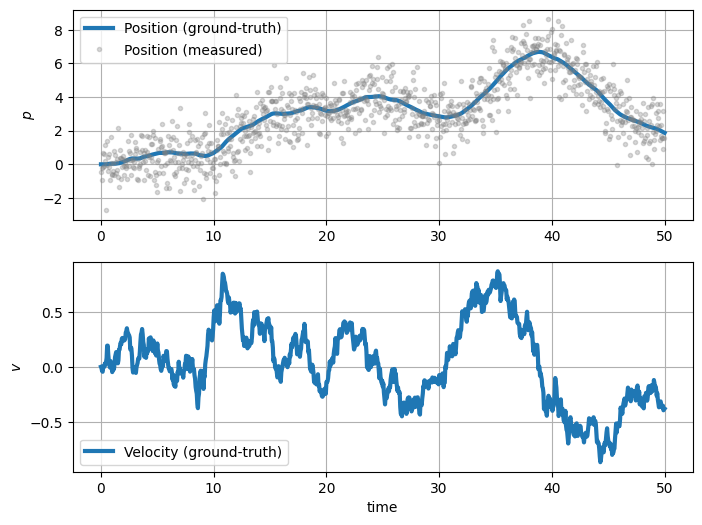

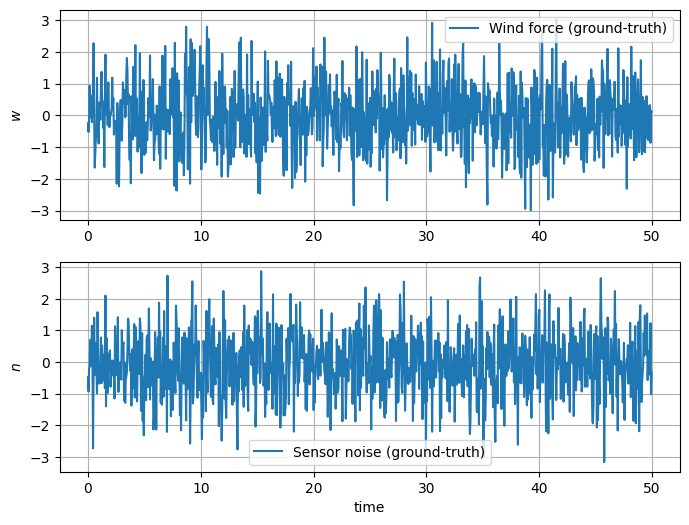

In [237]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

A[0,0] = 1
A[0,1] = (1-gamma*delt/2)*delt
A[1,1] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,0] = delt

C[0,0] = 1

np.random.seed(30010)

x = np.zeros((2,N+1))
x[:,0] = [0,0]
y = np.zeros((1,N))

w = np.random.randn(1,N)
n = np.random.randn(1,N)

for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])

x_true = x.copy()
w_true = w.copy()
n_true = n.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], linewidth=3, label='Position (ground-truth)')
plt.plot(ts[:-1],y[0,:], '.', color='gray', linewidth=2, alpha=0.3, \
         label='Position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], linewidth=3, label='Velocity (ground-truth)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],w_true[0,:], label='Wind force (ground-truth)')
plt.ylabel(r"$w$")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts[:-1],n_true[0,:], label='Sensor noise (ground-truth)')
plt.xlabel('time')
plt.ylabel(r'$n$')
plt.legend()
plt.grid()
plt.show()


<br>

So the problem is now to estimate $x_t = (p_t, v_t)$ with the given position measurement, $y_t$. We use the hat notation to denote the estimates. For example,

$$
  \hat{x}_t = (\hat{p}_t, \hat{v}_t)
$$

is the position and velocity estimates.


<br>

___

<br>

_**(Problem 1)**_
A very naive approach to compute the above state estimates is as follows.

<br>

1) Since the position ($p_t$) was measured by $y_t$, we believe our measurement entirely. In other words, we let

$$
\hat{p}^{\text{naive}}_t = y_t
$$

<br>/

2) Since we don't have direct measurements on the velocity ($v_t$), we numerically differentiate $\hat{p}^{\text{naive}}_t$ to compute $\hat{v}^{\text{naive}}_t$. In other words, we let

$$
  \hat{v}^{\text{naive}}_t = \frac{\hat{p}^{\text{naive}}_t - \hat{p}^{\text{naive}}_{t-1}}{\Delta t} = \frac{y_t-y_{t-1}}{\Delta t}
$$

<br>

Implement this, and compare the state estimates with the true state variables. Overlap $\hat{p}^{\text{naive}}_t$ and ${p}_t$ on a single plot, and $\hat{v}^{\text{naive}}_t$ and ${v}_t$ on another plot.

What do you observe?

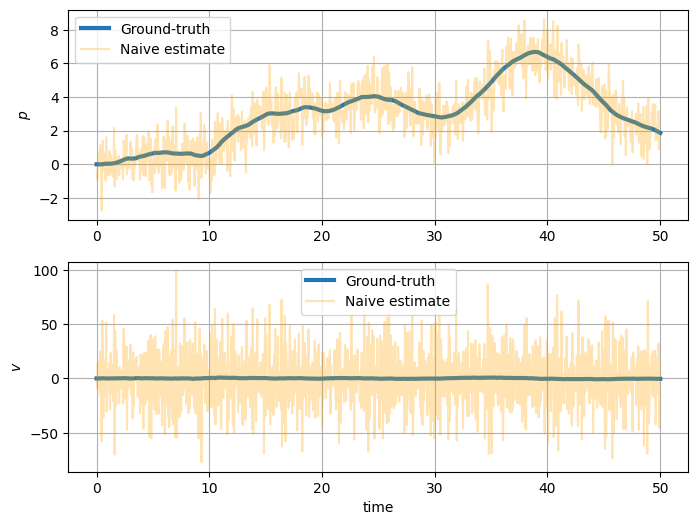

In [238]:
# your code here
p_hat_naive = y[0,:]
v_hat_naive = np.zeros(N)

for i in range(1,N) :
    v_hat_naive[i] = (p_hat_naive[i] - p_hat_naive[i-1])/delt


plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],p_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],v_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

### Limitations of the Naive Approach

As observed in the plots above, the naive estimation approach has significant limitations, particularly in the presence of noise.

1.  **Direct impact of measurement noise on position:** The naive position estimate $\hat{p}^{\text{naive}}_t = y_t$ directly uses the noisy measurement. This means any noise in the sensor reading is directly reflected in the position estimate.
2.  **Amplification of noise in velocity:** The velocity estimate is obtained by numerically differentiating the noisy position estimate: $\hat{v}^{\text{naive}}_t = \frac{y_t-y_{t-1}}{\Delta t}$. Numerical differentiation is known to amplify high-frequency noise. Since the measurement noise $n_t$ is IID, the difference $y_t - y_{t-1} = (Cx_t + n_t) - (Cx_{t-1} + n_{t-1})$ will still contain the noise components $n_t - n_{t-1}$, which can be significant and amplified when divided by the small time step $\Delta t$.
3.  **Ignoring system dynamics:** This approach does not utilize the known dynamics of the system ($x_{t+1} = Ax_t + Bw_t$). It treats each measurement independently for position and uses a simple difference for velocity, failing to incorporate the physical constraints and relationships between position and velocity over time.

To quantitatively assess the performance of this naive estimator, we will calculate the Mean Squared Error (MSE) for both the position and velocity estimates compared to their respective ground truth values. A lower MSE indicates a better estimate.


In [239]:
# your code here
MSE_p_naive = np.sum((x[0,1:]-p_hat_naive)**2)/len(p_hat_naive)
MSE_v_naive = np.sum((x[1,1:]-v_hat_naive)**2)/len(v_hat_naive)

print(f"MSE_p : {MSE_p_naive}")
print(f"MSE_v : {MSE_v_naive}")

MSE_p : 0.9835063206576871
MSE_v : 764.392320866276


<br>

___

<br>

_**(Problem 2)**_ Since the above estimates look severely corrupted by high frequency noise components, we would like to use low pass filters to smooth them out. Though there are sophisticated ways of designing and implementing the discrete-time low pass filters, we would go with a simle first-order recursive form described below.

The low-pas-filtered signal $\hat{p}^{\text{lpf}}_t$ for the naive estimate $\hat{p}^{\text{naive}}_t$ is given by

$$
\hat{p}^{\text{lpf}}_{t+1} = a  \hat{p}^{\text{lpf}}_{t} + b \left(\hat{p}^{\text{naive}}_{t+1} + \hat{p}^{\text{naive}}_{t}\right)
$$

where we will use $(a,b)=(0.9047619,0.04761905)$ for position estimates and $(a,b)=(0.99004975,0.00497512)$ for velocity estimates. The following cell computes these numbers, but you don't have to care about it.



In [193]:
import scipy.signal as sps
bw_p = 2
bw_v = 0.2
lpf_p = sps.cont2discrete(([bw_p],[1.,bw_p]), delt, method='bilinear')
lpf_v = sps.cont2discrete(([bw_v],[1.,bw_v]), delt, method='bilinear')
print(lpf_p)
print(lpf_v)

(array([[0.04761905, 0.04761905]]), array([ 1.       , -0.9047619]), 0.05)
(array([[0.00497512, 0.00497512]]), array([ 1.        , -0.99004975]), 0.05)


<br>

Using these coefficients, implement the low pass filter and compare the state estimates with the true state variables. Overlap $\hat{p}^{\text{lpf}}_t$ and ${p}_t$ on a single plot, and $\hat{v}^{\text{lpf}}_t$ and ${v}_t$ on another plot.

<br>

**Discussion on Filter Coefficients (a and b):**

The coefficients `a` and `b` in the low-pass filter equation control the characteristics of the filter. They represent a trade-off between smoothing the noisy signal and introducing lag in the filtered output.

*   **Smoothing vs. Lag:**
  - Higher values of `b` relative to `a` result in more weight given to the current and previous naive estimates ($\hat{p}^{\text{naive}}_{t+1}$ and $\hat{p}^{\text{naive}}_{t}$). This leads to more aggressive smoothing of the signal, effectively reducing the impact of high-frequency noise. However, this also means the filter's output will respond more slowly to actual changes in the signal, introducing a delay or lag.

  - Lower values of `b` relative to `a` give more weight to the previous filtered estimate ($\hat{p}^{\text{lpf}}_t$). This results in less smoothing, meaning more of the noise might still be present in the output. However, the filter will react more quickly to changes in the input, reducing lag.

You will experiment with different values of `a` and `b` for both the position and velocity filters in the following code cell and observe their impact on the estimates and the calculated error metrics.

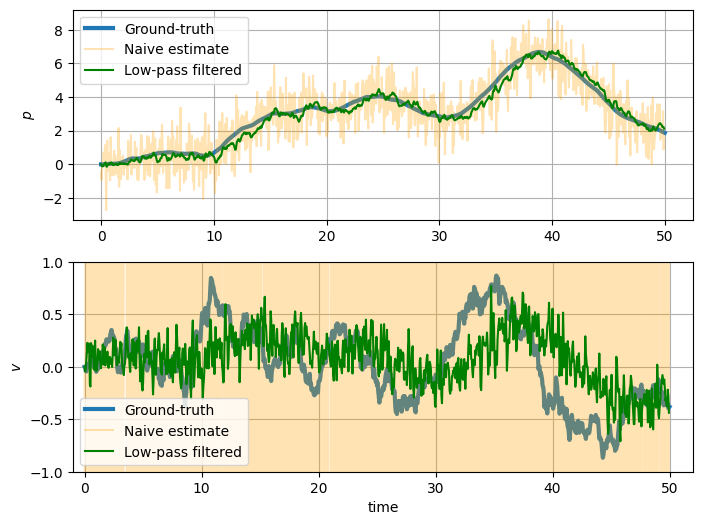

MSE_p : 0.09942130004698513
MSE_v : 0.11384864186776181


In [241]:
# your code here
p_hat_lpf = np.zeros(N)
v_hat_lpf = np.zeros(N)

for i in range(N-1) :
    p_hat_lpf[i+1] = 0.9047619*p_hat_lpf[i] + 0.04761905*(p_hat_naive[i+1]+p_hat_naive[i])
    v_hat_lpf[i+1] = 0.99004975*v_hat_lpf[i] + 0.00497512*(v_hat_naive[i+1]+v_hat_naive[i])

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],p_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],p_hat_lpf, color='green', label='Low-pass filtered')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],v_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],v_hat_lpf, color='green', label='Low-pass filtered',zorder =3)
plt.ylim(-1,1)
plt.xlim(-1,52)
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

MSE_p_lpf = np.sum((x[0,1:]-p_hat_lpf)**2)/len(p_hat_lpf)
MSE_v_lpf = np.sum((x[1,1:]-v_hat_lpf)**2)/len(v_hat_lpf)

print(f"MSE_p : {MSE_p_lpf}")
print(f"MSE_v : {MSE_v_lpf}")

<br>

Reflect on the impact of changing the filter coefficients (`a` and `b`) on the plots and the calculated MSE values. Discuss the observed trade-off between smoothing and lag. How did increasing `b` relative to `a` affect the smoothness of the estimated signals and their alignment with the ground truth? How did decreasing `b` relative to `a` impact these aspects?

<br>

___

<br>

_**(Problem 3)**_ An alpha beta filter presumes that a system is adequately approximated by a model having two internal states, where the first state is obtained by integrating the value of the second state over time. Measured system output values correspond to observations of the first model state, plus disturbances. This very low order approximation is adequate for many simple systems, for example, mechanical systems where position is obtained as the time integral of velocity.

Assuming that velocity remains approximately constant over the small time interval $\Delta t$ between measurements, the position state is projected forward to predict its value at the next sampling time using

$$
\tilde{p}_t = \hat{p}_{t-1} + \Delta t \hat{v}_{t-1}
$$

Since velocity variable $v$ is presumed constant, its projected value at the next sampling time equals the current value.

$$
\tilde{v}_t = \hat{v}_{t-1}
$$

If additional information is known about how a driving function will change the $v$ state during each time interval, this can be modified to include it.

<br>

The output measurement is expected to deviate from the prediction because of noise and dynamic effects not included in the simplified dynamic model. This prediction error $r_t$ is also called the residual or innovation,

$$
 r_t = y_t - \tilde{p}_t
$$

<br>

Suppose that the residual $r_t$ is positive. This discrepancy can occur if the previous $p_t$ estimate or $v_t$ estimate was low, or some combination of the two was low. The alpha beta filter takes selected alpha and beta constants (from which the filter gets its name), uses alpha times the deviation $r_t$ to correct the position estimate, and uses beta times the deviation $r_t$ to correct the velocity estimate. An extra $\Delta t$ factor conventionally serves to normalize magnitudes of the multipliers.

$$
\begin{aligned}
\hat{p}_{t+1} &= \tilde{p}_{t} + \alpha\left(y_t - \tilde{p}_t \right) \\
\hat{v}_{t+1} &= \tilde{v}_{t} + \frac{\beta}{\Delta t} \left(y_t - \tilde{p}_t \right)
\end{aligned}
$$

The corrections can be considered small steps along an estimate of the gradient direction. As these adjustments accumulate, error in the state estimates is reduced. Typical choices are

$$
0 < \alpha , \beta < 1
$$

<vr>



The corrections can be considered small steps along an estimate of the gradient direction. As these adjustments accumulate, error in the state estimates is reduced. Typical choices are

$$
0 < \alpha , \beta < 1
$$

Values of $\alpha$ and $\beta$ typically are adjusted experimentally. In general, larger $\alpha$ and $\beta$ gains tend to produce faster response for tracking transient changes, while smaller alpha and beta gains reduce the level of noise in the state estimates. If a good balance between accurate tracking and noise reduction is found, and the algorithm is effective, filtered estimates are more accurate than the direct measurements. This motivates calling the alpha-beta process a filter.

<br>

**Understanding Alpha and Beta Selection:**

The parameters $\alpha$ and $\beta$ are crucial in determining the performance of the alpha-beta filter. They represent gains that weigh the importance of the new measurement innovation ($r_t$) against the predicted state.

*   **Alpha ($\alpha$):** This parameter directly affects how much the position estimate is corrected based on the measurement residual.
    *   **Higher $\alpha$:** The filter gives more weight to the new measurement. This leads to faster tracking of actual changes in position but also makes the position estimate more susceptible to measurement noise.
    *   **Lower $\alpha$:** The filter relies more on the predicted position based on the previous state. This results in smoother position estimates with less noise but can introduce lag in tracking rapid position changes.

*   **Beta ($\beta$):** This parameter influences how much the velocity estimate is corrected based on the measurement residual. Since the velocity is derived from changes in position, $\beta$ indirectly affects the velocity estimate's response to position changes and the impact of noise.
    *   **Higher $\beta$:** The filter makes larger corrections to the velocity estimate based on the position residual. This can help the filter track changes in velocity more quickly, but because the residual is based on a noisy position measurement, a higher $\beta$ can amplify noise in the velocity estimate.
    *   **Lower $\beta$:** The filter makes smaller corrections to the velocity estimate. This leads to smoother velocity estimates with less noise but can make the filter slower to respond to actual changes in velocity.

The choice of $\alpha$ and $\beta$ involves a trade-off between responsiveness (ability to track changes) and noise reduction. These parameters should ideally be related to the system dynamics (e.g., how quickly position and velocity can change) and the characteristics of the measurement and process noise. A system with high process noise or rapid dynamics might require higher $\alpha$ and $\beta$, while a system with high measurement noise might benefit from lower values.

<br>

You will now implement the alpha-beta filter and experiment with different combinations of $\alpha$ and $\beta$ to observe their impact on the estimates and quantitatively evaluate their performance using the Mean Squared Error (MSE).


$\alpha$ = 0.03,$\beta$ = 0.003, 바꿔가면서도 해봐라
 

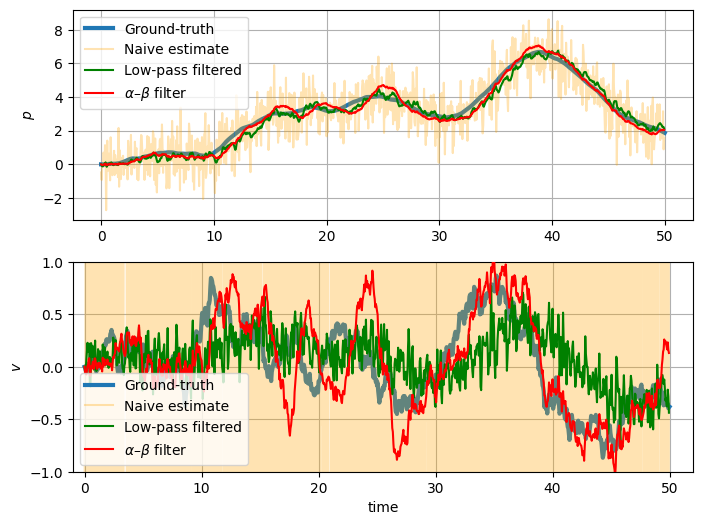

MSE_p : 0.08910549478832848
MSE_v : 0.09794323447590082


In [258]:
# your code here
p_hat = np.zeros(N)
v_hat = np.zeros(N)
p_tilda = np.zeros(N)
v_tilda = np.zeros(N)
alpha = 0.03
beta = 0.003

for i in range(1,N) :
    p_tilda[i] = p_hat[i-1] + delt*v_hat[i-1]
    v_tilda[i] = v_hat[i-1]
    p_hat[i] = p_tilda[i] + alpha*(y[0,i] - p_tilda[i])
    v_hat[i] = v_tilda[i] + beta/delt*(y[0,i] - p_tilda[i])

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],p_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],p_hat_lpf, color='green', label='Low-pass filtered')
plt.plot(ts[:-1],p_hat, color='red', label=r'$\alpha$–$\beta$ filter',zorder =4)
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],v_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],v_hat_lpf, color='green', label='Low-pass filtered',zorder =3)
plt.plot(ts[:-1],v_hat, color='red', label=r'$\alpha$–$\beta$ filter',zorder =4)
plt.ylim(-1,1)
plt.xlim(-1,52)
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

MSE_p_abf = np.mean((x[0,1:]-p_hat[:])**2)
MSE_v_abf = np.mean((x[1,1:]-v_hat[:])**2)

print(f"MSE_p : {MSE_p_abf}")
print(f"MSE_v : {MSE_v_abf}")

Reflect on the impact of changing the $\alpha$ and $\beta$ values on the plots and the calculated MSE values.

Experiment with different combinations of $\alpha$ and $\beta$. For example, try:
- Increasing $\alpha$ while keeping $\beta$ constant.
- Decreasing $\alpha$ while keeping $\beta$ constant.
- Increasing $\beta$ while keeping $\alpha$ constant.
- Decreasing $\beta$ while keeping $\alpha$ constant.
- Increasing both $\alpha$ and $\beta$.
- Decreasing both $\alpha$ and $\beta$.

For each combination you try, observe the following:
- **Visual Observations from Plots:** How does changing $\alpha$ and $\beta$ affect the smoothness of the estimated position and velocity curves? Do the estimates track the ground truth more closely or is there more lag or overshoot?
- **Quantitative Observations from MSE:** How do the MSE values for position and velocity change with different $\alpha$ and $\beta$ values?

Discuss the trade-offs you observe when changing $\alpha$ and $\beta$. How do these parameters relate to the filter's ability to balance noise reduction (resulting in smoother estimates and potentially lower MSE in the presence of noise) and tracking performance (resulting in less lag and potentially lower MSE when the true state is changing)? Based on your experiments, what values of $\alpha$ and $\beta$ seem to provide a good balance for this specific dataset and system dynamics?

### Increasing $\alpha$ while keeping $\beta$ constant

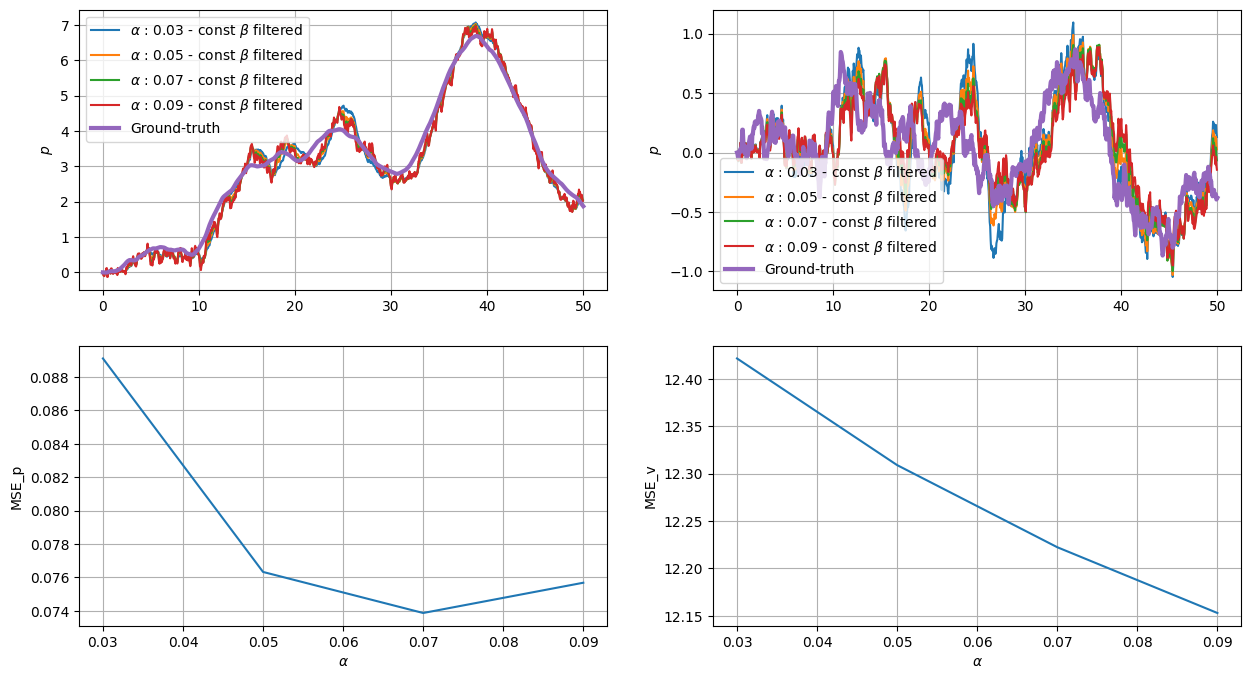

In [196]:
alpha_inc_list = [0.03, 0.05, 0.07, 0.09]

p_hat_alpha_inc = np.zeros(N)
v_hat_alpha_inc = np.zeros(N)
MSE_p_alpha_inc =[]
MSE_v_alpha_inc = []


plt.figure(figsize=(15,8), dpi=100)
for i in alpha_inc_list :
    for j in range(1, N):
        p_tilda[j] = p_hat_alpha_inc[j-1] + delt*v_hat_alpha_inc[j-1]
        v_tilda[j] = v_hat_alpha_inc[j-1]
        p_hat_alpha_inc[j] = p_tilda[j] + i*(y[0,j] - p_tilda[j])
        v_hat_alpha_inc[j] = v_tilda[j] + beta/delt*(y[0,j] - p_tilda[j])

    MSE_p_alpha_inc.append(np.sum((x[0,1:]-p_hat_alpha_inc)**2)/len(p_hat_alpha_inc))
    MSE_v_alpha_inc.append(np.sum((x[0,1:]-v_hat_alpha_inc)**2)/len(v_hat_alpha_inc))
        

    plt.subplot(2,2,1)
    plt.plot(ts[:-1], p_hat_alpha_inc, label =fr"$\alpha$ : ${i}$ - const $\beta$ filtered")
    plt.subplot(2,2,2)
    plt.plot(ts[:-1], v_hat_alpha_inc, label =fr"$\alpha$ : ${i}$ - const $\beta$ filtered")


plt.subplot(2,2,1)
plt.plot(ts,x[0,:], linewidth=3, label='Ground-truth')
plt.legend()
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(ts,x[1,:], linewidth=3, label='Ground-truth')
plt.legend()
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(alpha_inc_list, MSE_p_alpha_inc)
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE_p")
plt.grid()

plt.subplot(2,2,4)
plt.plot(alpha_inc_list, MSE_v_alpha_inc)
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE_v")
plt.grid()




### Increasing $\beta$ while keeping $\alpha$ constant.

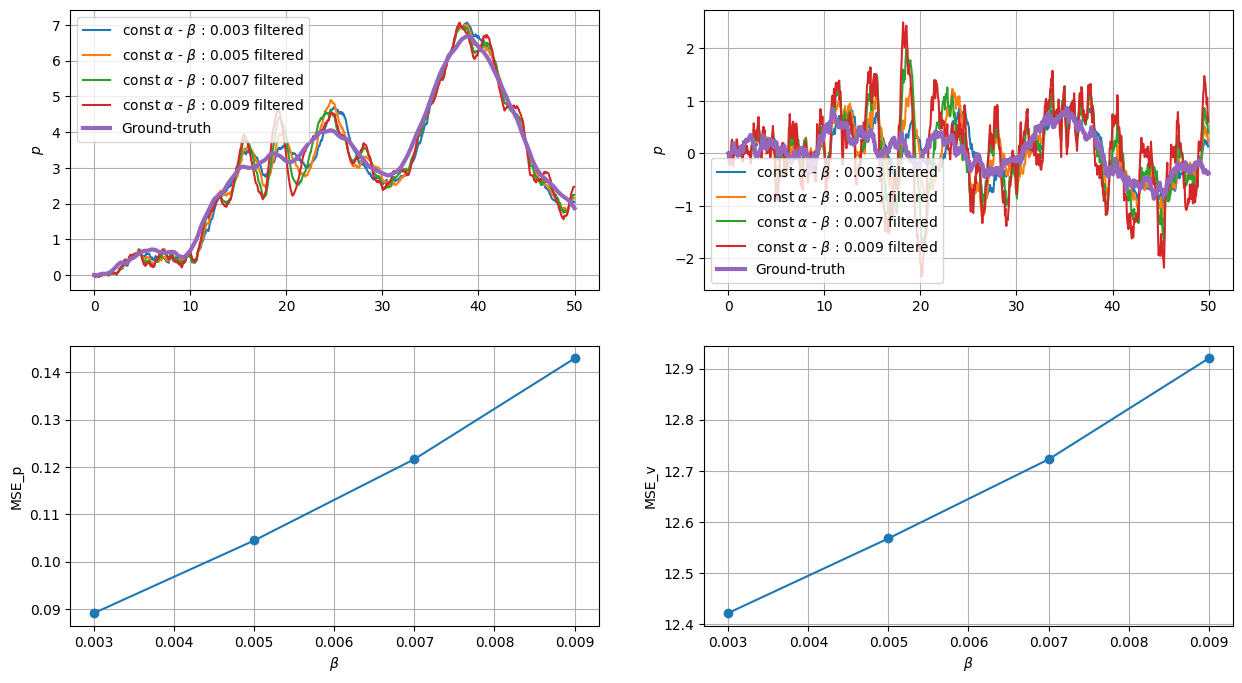

In [197]:
beta_inc_list = [0.003, 0.005, 0.007, 0.009]

p_hat_beta_inc = np.zeros(N)
v_hat_beta_inc = np.zeros(N)
MSE_p_beta_inc =[]
MSE_v_beta_inc = []

alpha = 0.03
plt.figure(figsize=(15,8), dpi=100)
for i in beta_inc_list :
    for j in range(1, N):
        p_tilda[j] = p_hat_beta_inc[j-1] + delt*v_hat_beta_inc[j-1]
        v_tilda[j] = v_hat_beta_inc[j-1]
        p_hat_beta_inc[j] = p_tilda[j] + alpha*(y[0,j] - p_tilda[j])
        v_hat_beta_inc[j] = v_tilda[j] + i/delt*(y[0,j] - p_tilda[j])

    MSE_p_beta_inc.append(np.sum((x[0,1:]-p_hat_beta_inc)**2)/len(p_hat_beta_inc))
    MSE_v_beta_inc.append(np.sum((x[0,1:]-v_hat_beta_inc)**2)/len(v_hat_beta_inc))
        

    plt.subplot(2,2,1)
    plt.plot(ts[:-1], p_hat_beta_inc, label =fr"const $\alpha$ - $\beta$ : ${i}$ filtered")
    plt.subplot(2,2,2)
    plt.plot(ts[:-1], v_hat_beta_inc, label =fr"const $\alpha$ - $\beta$ : ${i}$ filtered")


plt.subplot(2,2,1)
plt.plot(ts,x[0,:], linewidth=3, label='Ground-truth')
plt.legend()
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(ts,x[1,:], linewidth=3, label='Ground-truth')
plt.legend()
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(beta_inc_list, MSE_p_beta_inc,'o-')
plt.xlabel(r"$\beta$")
plt.ylabel("MSE_p")
plt.grid()

plt.subplot(2,2,4)
plt.plot(beta_inc_list, MSE_v_beta_inc,'o-')
plt.xlabel(r"$\beta$")
plt.ylabel("MSE_v")
plt.grid()



### Increasing both $\alpha$ and $\beta$.

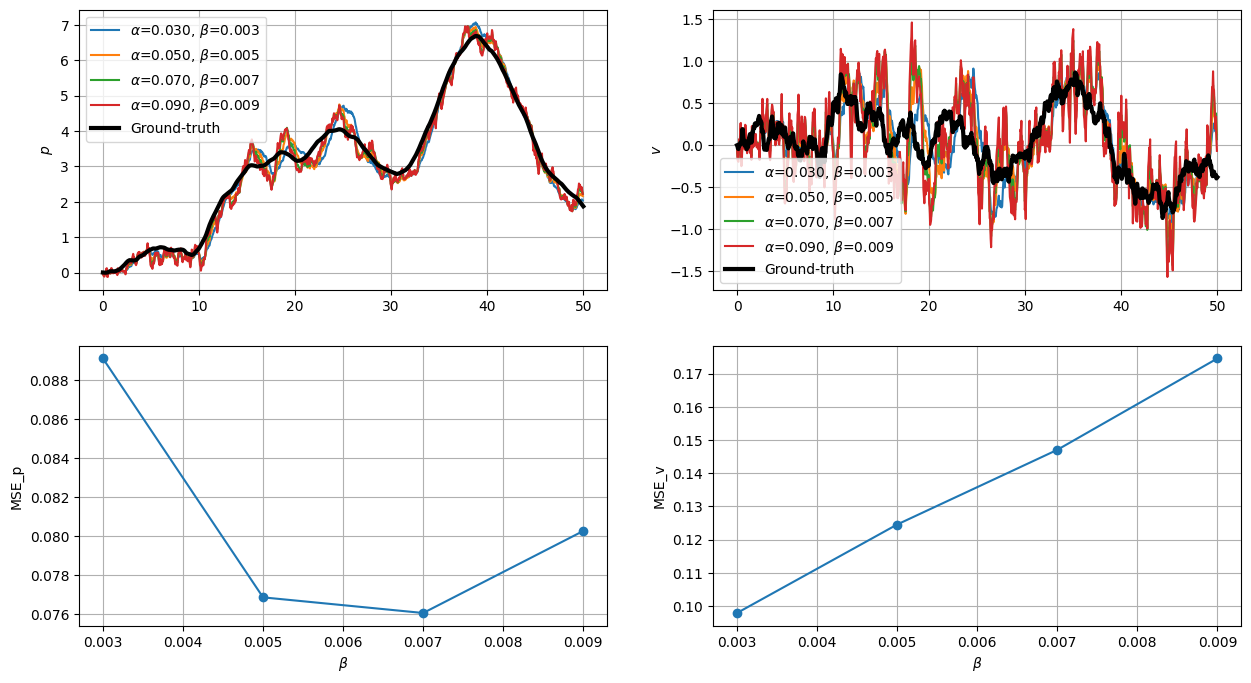

In [198]:
alpha_inc_list = [0.03, 0.05, 0.07, 0.09]
beta_inc_list  = [0.003, 0.005, 0.007, 0.009]

# 결과 저장용
MSE_p_alpha_beta_inc = []
MSE_v_alpha_beta_inc = []

plt.figure(figsize=(15,8), dpi=100)

# α, β를 동시에 증가시키는 루프
for alpha, beta in zip(alpha_inc_list, beta_inc_list):
    # --- 초기화 ---
    p_hat_alpha_beta_inc = np.zeros(N)
    v_hat_alpha_beta_inc = np.zeros(N)
    p_tilda = np.zeros(N)
    v_tilda = np.zeros(N)

    # --- 필터 반복 ---
    for j in range(1, N):
        p_tilda[j] = p_hat_alpha_beta_inc[j-1] + delt * v_hat_alpha_beta_inc[j-1]
        v_tilda[j] = v_hat_alpha_beta_inc[j-1]
        residual = y[0, j] - p_tilda[j]
        p_hat_alpha_beta_inc[j] = p_tilda[j] + alpha * residual
        v_hat_alpha_beta_inc[j] = v_tilda[j] + (beta / delt) * residual

    # --- MSE 계산 ---
    MSE_p = np.mean((x[0, 1:] - p_hat_alpha_beta_inc)**2)
    MSE_v = np.mean((x[1, 1:] - v_hat_alpha_beta_inc)**2)
    MSE_p_alpha_beta_inc.append(MSE_p)
    MSE_v_alpha_beta_inc.append(MSE_v)

    # --- 그래프 ---
    plt.subplot(2,2,1)
    plt.plot(ts[:-1], p_hat_alpha_beta_inc, label=fr'$\alpha$={alpha:.3f}, $\beta$={beta:.3f}')
    
    plt.subplot(2,2,2)
    plt.plot(ts[:-1], v_hat_alpha_beta_inc, label=fr'$\alpha$={alpha:.3f}, $\beta$={beta:.3f}')


# --- Ground Truth ---
plt.subplot(2,2,1)
plt.plot(ts, x[0,:], 'k', linewidth=3, label='Ground-truth')
plt.legend(); plt.ylabel(r'$p$'); plt.grid()

plt.subplot(2,2,2)
plt.plot(ts, x[1,:], 'k', linewidth=3, label='Ground-truth')
plt.legend(); plt.ylabel(r'$v$'); plt.grid()

# --- MSE 그래프 ---
plt.subplot(2,2,3)
plt.plot(beta_inc_list, MSE_p_alpha_beta_inc, 'o-')
plt.xlabel(r"$\beta$"); plt.ylabel("MSE_p"); plt.grid()

plt.subplot(2,2,4)
plt.plot(beta_inc_list, MSE_v_alpha_beta_inc, 'o-')
plt.xlabel(r"$\beta$"); plt.ylabel("MSE_v"); plt.grid()


### 결론
알파-베타 필터 파라미터 실험 결과
세 가지 실험(α만 증가, β만 증가, 둘 다 증가)을 통해 파라미터가 필터 성능에 미치는 영향을 분석했다.
 - α(알파) 파라미터의 영향:
α를 증가시키면 위치 추정이 측정값에 더 빠르게 반응하여 지연이 줄어든다. 하지만 α가 너무 크면 속도 추정에서 노이즈가 증가한다. MSE 그래프를 보면 위치 오차는 α=0.05-0.07 부근에서 최소값을 가지는 U자 형태를 보인다. 반면 속도 오차는 α가 증가할수록 감소하는 경향을 보인다.
- β(베타) 파라미터의 영향:
β를 증가시키면 속도 추정의 보정이 강해지지만, 측정 노이즈가 속도 추정치에 크게 증폭되어 나타난다. 실험 결과 β가 증가할수록 위치와 속도 모두 MSE가 단조 증가했다. 특히 속도 오차의 증가폭이 매우 컸다. 따라서 β는 작은 값을 유지하는 것이 유리하다.
 - 두 파라미터를 동시에 증가시킨 경우:
α와 β를 함께 증가시키면 위 두 효과가 복합적으로 나타난다. 위치 추정은 중간 값에서 최적 성능을 보이지만, 속도 추정의 노이즈는 급격히 증가한다.
- 결론:
이 데이터셋에서는 α=0.05-0.07, β=0.003-0.005 정도가 최적 조합으로 보인다. 알파-베타 필터는 빠른 추적 성능과 노이즈 억제 사이의 trade-off를 보여준다. 특히 β는 속도 추정의 노이즈에 민감하므로 신중하게 선택해야 한다. 측정 노이즈가 있고 시스템 동역학이 비교적 느린 이 경우, 보수적인(낮은) 파라미터 값이 더 나은 성능을 보였다.

<br>

___

<br>

_**(Problem 4)**_ A better (actually the best) way in short is as follows. We begin with the state estimate, $\hat{x}_t$, and the error covariance of the state variable, $\Sigma_t$, and will recursively propagate them.

\begin{align*}
\hat{x}_t &= \mathbf{E}\left(x_t \ \vert\ y_0, y_1, \dots, y_{t-1} \right) \\
\Sigma_t &= \mathbf{cov}\left(x_t \ \vert\ y_0, y_1, \dots, y_{t-1} \right)
\end{align*}

Here, $\hat{x}_t$ can be interpreted as the state estimate at time $t$ given observations up to time $t-1$ (this is the *a priori* estimate), and $\Sigma_t$ is the error covariance matrix which explains the estimated accuracy of the state estimates given observations up to time $t-1$. These should be described in way more details, however we will not go into that and the above simple explanation would be sufficient for understanding elementary mechanisms of optimal state estimation.

**Theoretical Underpinnings of the Kalman Filter:**

The Kalman filter is a recursive algorithm that provides an optimal estimate of the state of a linear dynamical system. Its optimality lies in minimizing the mean squared error (MSE) of the state estimate, provided that the system dynamics are linear and the process and measurement noises are Gaussian and uncorrelated.

The filter operates in a two-step process:

1.  **Prediction (Time Update):** Using the system dynamics model, the filter predicts the state and its covariance at the next time step based on the current estimate.
2.  **Update (Measurement Update):** When a new measurement becomes available, the filter updates the predicted state and covariance by incorporating the information from the measurement. The degree to which the measurement influences the update is determined by the Kalman gain, which weights the innovation (the difference between the actual measurement and the predicted measurement).

The recursive nature means that the filter only needs the state estimate and its covariance from the previous time step and the current measurement to compute the current estimate. It doesn't need the entire history of measurements.

The optimality of the Kalman filter under the assumptions of linearity and Gaussian noise is a significant result. For linear systems with Gaussian noise, the conditional probability distribution of the state given the measurements is also Gaussian. The Kalman filter effectively computes the mean and covariance of this conditional distribution, which for a Gaussian distribution, are the minimum variance (and thus minimum MSE) estimates.

1. The optimal Kalman gain is defined by:

$$
K_t = \Sigma_tC^T \left( C\Sigma_t C^T + \Sigma_v \right)^{-1}.
$$

2. A posteriori state estimate is updated as:

$$
\hat{x}_{t}^+ = \hat{x}_t + K_t \left( y_t - C \hat{x}_t \right).
$$

3. A posteriori estimate covariance is updated as:

$$
\Sigma_{t}^+ = \Sigma_t - \Sigma_t C^T \left(C\Sigma_t C^T + \Sigma_v \right)^{-1}C\Sigma_t.
$$

4. A priori state estimate is predicted as:

$$
\hat{x}_{t+1} = A \hat{x}_{t}^+.
$$

5. A priori estimate covariance is predicted as:

$$
\Sigma_{t+1} = A \Sigma_t^+ A^T + \Sigma_w,
$$

where $\Sigma_w$ represents the covariance of the dicturbance input, $Bw_t$. Since we assumed that $w_t$ follows the IID zero mean Gaussian random noise with variance 1, we have that $\Sigma_w=BB^T$. This procedure corresponds to conditioning the Gaussian distibution using the new measurement information via Bayesian inference, and propagating it under the affine dynamical relation.

**Extensions for Nonlinear Systems: The Extended Kalman Filter (EKF)**

While the standard Kalman filter is optimal for linear systems, many real-world systems are nonlinear. For such systems, the Extended Kalman Filter (EKF) is often used. The EKF approximates the nonlinear system dynamics and measurement models by linearizing them around the current state estimate using Jacobian matrices. The standard Kalman filter equations are then applied to this linearized system.

It's important to note that the EKF is an approximation and is not guaranteed to be optimal, especially for highly nonlinear systems. However, it is a widely used and effective method for state estimation in many nonlinear applications.

For the linear system described in this problem, the standard Kalman filter is the theoretically optimal filter and the EKF would reduce to the standard Kalman filter because the Jacobian matrices of the linear system are simply the matrices A and C themselves. Therefore, we will implement the standard Kalman filter here.

Implement this, and compare the state estimates with the true state variables. Compare your results with the naive estimates and the low-pass-filtered estimates. You may simply assume that $\hat{x}=(0,0)$ and $\Sigma_0 = 10I$; you will notice that your solution will be robust to changes in these initial conditions.

The above procedure is called the *Kalman filtering*, and it turns out to be optimal, in other words most accurate, under some technical conditions.

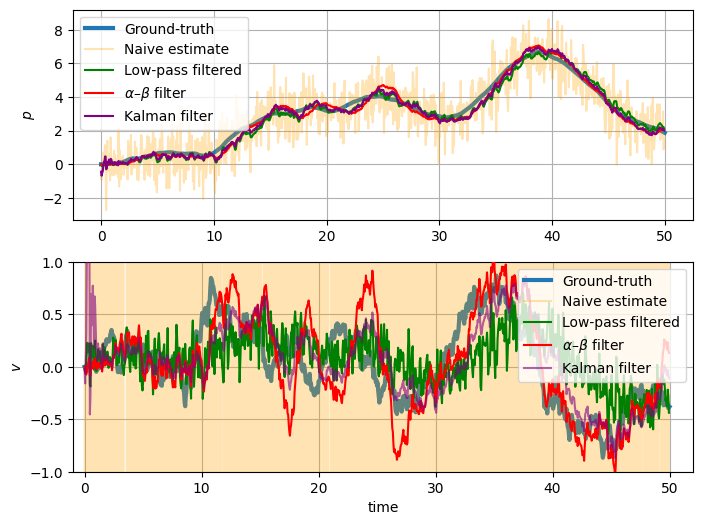

MSE_p : 0.07837698341185552
MSE_v : 0.08705393994604797


In [267]:
# your code here
# --- Kalman Filter (정상 동작, 첫 관측부터 보정 시작) ---
x_hat0 = np.array([0, 0])           # 초기 상태
cov0 = 10 * np.eye(2)               # 초기 공분산
sigma_v = np.eye(1)                 # Measurement noise
sigma_w = np.dot(B, B.T)            # Process noise

x_kalman = np.zeros_like(x)         # 결과 저장
y = np.atleast_2d(y)                # (1, N) 형태 보장

for i in range(N):    
    # --- Prediction step ---
    x_hat_prior = A @ x_hat0
    cov_prior = A @ cov0 @ A.T + sigma_w

    # --- Update step ---
    K = cov_prior @ C.T @ np.linalg.inv(C @ cov_prior @ C.T + sigma_v)
    y_t = y[0, i]
    x_hat_update = x_hat_prior + K @ (y_t - C @ x_hat_prior)
    sigma_update = cov_prior - cov_prior @ C.T @ np.linalg.inv(C @ cov_prior @ C.T + sigma_v) @ C @ cov_prior

    # --- Store posterior (현재 추정값) ---
    x_kalman[:, i] = x_hat_update.flatten()

    # --- Prepare for next iteration ---
    x_hat0 = x_hat_update
    cov0 = sigma_update

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],p_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],p_hat_lpf, color='green', label='Low-pass filtered')
plt.plot(ts[:-1],p_hat, color='red', label=r'$\alpha$–$\beta$ filter',zorder =4)
plt.plot(ts[:-1],x_kalman[0,:-1], color='purple', label='Kalman filter',zorder =5)
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],v_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],v_hat_lpf, color='green', label='Low-pass filtered',zorder =3)
plt.plot(ts[:-1],v_hat, color='red', label=r'$\alpha$–$\beta$ filter',zorder =4)
plt.plot(ts[:-1],x_kalman[1,:-1], color='purple', alpha =0.6,label='Kalman filter',zorder =5)
plt.ylim(-1,1)
plt.xlim(-1,52)
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

MSE_p_kalman = np.mean((x[0,:]-x_kalman[0,:])**2)
MSE_v_kalman = np.mean((x[1,:]-x_kalman[1,:])**2)

print(f"MSE_p : {MSE_p_kalman}")
print(f"MSE_v : {MSE_v_kalman}")

<br>

Reflect on the performance of the Kalman filter compared to the naive, low-pass, and alpha-beta filters based on the plots and the calculated MSE values.

Observe the following:
- **Visual Comparison in Plots:** How do the Kalman filter estimates for position and velocity visually compare to the ground truth and the estimates from the other filters? Is it smoother than the naive estimate? Does it track the ground truth better than the low-pass and alpha-beta filters, particularly during changes in velocity?
- **Quantitative Comparison using MSE:** Compare the Mean Squared Error values for the position and velocity estimates from all four methods (Naive, Low-Pass Filtered, Alpha-Beta Filtered, and Kalman Filtered). Which filter achieved the lowest MSE for position and velocity?

Discuss why the Kalman filter is expected to perform better than the other filters under the assumptions of this problem (linear system, Gaussian process and measurement noise). How do the theoretical properties of the Kalman filter (optimality in minimizing MSE under these conditions) manifest in the practical results you observe?

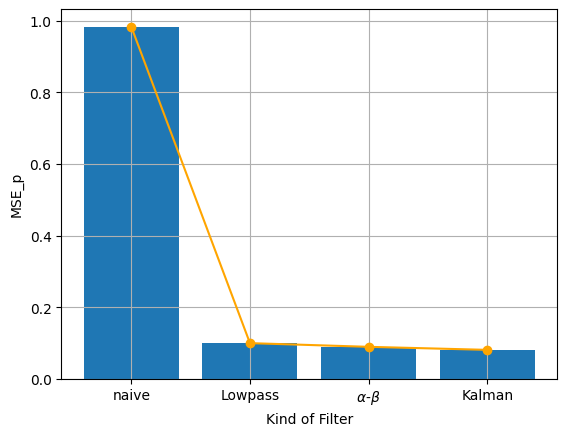

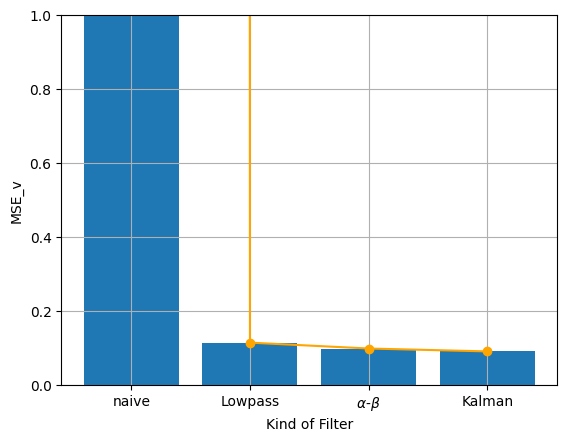

In [223]:
fiter_name = ["naive", "Lowpass", r"$\alpha$-$\beta$", "Kalman"]
MSE_p_list = [MSE_p_naive, MSE_p_lpf, MSE_p_abf, MSE_p_kalman]
MSE_v_list = [MSE_v_naive, MSE_v_lpf, MSE_v_abf, MSE_v_kalman]

plt.bar(fiter_name, MSE_p_list)
plt.plot(fiter_name, MSE_p_list, "o-", color ="orange")
plt.grid()
plt.xlabel("Kind of Filter")
plt.ylabel("MSE_p")
plt.show()

plt.bar(fiter_name, MSE_v_list)
plt.plot(fiter_name, MSE_v_list, "o-", color ="orange")
plt.grid()
plt.xlabel("Kind of Filter")
plt.ylim(0,1.0)
plt.ylabel("MSE_v")
plt.show()

### 결론
naive보다 필터를 적용하면 에러를 현저하게 줄일 수 있고, Low pass와 $\alpha$-$\beta$ filter는 동역학을 적용시키지 않고 필터링을 하고, Kalman의 경우 동역학 전파를 한 후 필터링을 적용하기 때문에 더 정확함을 알 수 있다, 결론적으로 Kalman filter는 선형 시스템과 가우시안 잡음이라는 가정하에서
MSE를 최소화하는 최적 추정기(Optimal Estimator)로서 이론적·실험적으로 모두 우수한 결과를 보였다.
그래프상으로는 가장 부드럽고 Ground truth에 근접하며, 수치적으로도 최소의 오차를 달성하였다.
따라서 본 실험에서는 Kalman filter가 위치 및 속도 추정 모두에서 가장 신뢰성 높은 필터링 기법임을 확인할 수 있다.


---

<br>

_**(Problem 5)**_  ***Handling Missing Data***


In real-world applications, data is not always available at every time step. Sensors might fail temporarily, communication links could be interrupted, or data might be deliberately sampled at different rates. Handling missing measurements is a common challenge in state estimation.

When a measurement $y_t$ is missing at time $t$, the Kalman filter cannot perform the standard measurement update step because there is no new information to incorporate. In such cases, the filter should skip the update step and rely solely on the prediction step to propagate the state estimate and its covariance to the next time step.

Specifically, if $y_t$ is missing:
- The Kalman gain $K_t$ is not calculated.
- The a posteriori state estimate $\hat{x}_t^+$ is not updated using a measurement. Instead, the a priori estimate $\hat{x}_t$ becomes the a posteriori estimate for this time step: $\hat{x}_t^+ = \hat{x}_t$.
- The a posteriori estimate covariance $\Sigma_t^+$ is not updated using a measurement. Instead, the a priori covariance $\Sigma_t$ becomes the a posteriori covariance: $\Sigma_t^+ = \Sigma_t$.
- The prediction step for the next time step ($t+1$) then uses these "unchanged" a posteriori estimates: $\hat{x}_{t+1} = A \hat{x}_t^+$ and $\Sigma_{t+1} = A \Sigma_t^+ A^T + \Sigma_w$.

Consider a scenario where every 10th measurement in the `y` data is missing (set these values to `None` or `np.nan` to indicate missingness).

Your task is to:
1. Create a copy of the `y` array and set every 10th measurement to `np.nan` to simulate missing data.
2. Modify the Kalman filter implementation to handle these missing data points. Inside the loop, check if the current measurement `y[0, t]` is `np.nan`.
3. If the measurement is *not* missing, perform the standard Kalman filter update step as before.
4. If the measurement *is* missing, skip the update step. The a priori state estimate and covariance will be carried forward as the a posteriori estimates for that time step.
5. Run the modified Kalman filter with the missing data and plot the resulting position and velocity estimates against the ground truth and the estimates from the other filters (Naive, LPF, Alpha-Beta, and the original Kalman filter without missing data).
6. Calculate and compare the MSE for the Kalman filter estimates with and without missing data.


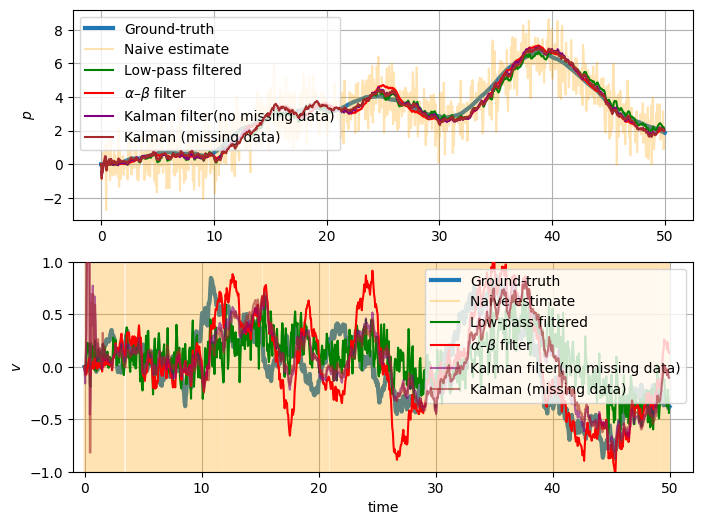

=== Kalman Filter (완전한 데이터) ===
MSE_p : 0.07837698341185552
MSE_v : 0.08705393994604797

=== Kalman Filter (결측치 포함) ===
MSE_p : 0.08601354514127581
MSE_v : 0.08654410212492436

결측치로 인한 MSE 증가:
Position: 0.007637
Velocity: -0.000510


In [269]:
# your code here
# your code here
# --- 결측치 데이터 생성 ---
y_missing = y.copy()
for i in range(0, N, 10):  # 매 10번째 측정값을 결측치로 설정
    y_missing[0, i] = np.nan

# --- Kalman Filter with Missing Data ---
x_hat0 = np.array([0, 0])           # 초기 상태
cov0 = 10 * np.eye(2)               # 초기 공분산
sigma_v = np.eye(1)                 # Measurement noise
sigma_w = np.dot(B, B.T)            # Process noise

x_kalman_missing = np.zeros_like(x)  # 결과 저장
y_missing = np.atleast_2d(y_missing) # (1, N) 형태 보장

for i in range(np.shape(y_missing)[1]):
    # --- Prediction step (항상 수행) ---
    x_hat_prior = A @ x_hat0
    cov_prior = A @ cov0 @ A.T + sigma_w

    # --- Check if measurement is missing ---
    if np.isnan(y_missing[0, i]):
        # 측정값이 없으면 Update step을 건너뛰고 prior를 그대로 사용
        x_hat_update = x_hat_prior
        sigma_update = cov_prior
    else:
        # --- Update step (측정값이 있을 때만 수행) ---
        K = cov_prior @ C.T @ np.linalg.inv(C @ cov_prior @ C.T + sigma_v)
        y_t = y_missing[0, i]
        x_hat_update = x_hat_prior + K @ (y_t - C @ x_hat_prior)
        sigma_update = cov_prior - cov_prior @ C.T @ np.linalg.inv(C @ cov_prior @ C.T + sigma_v) @ C @ cov_prior

    # --- Store posterior ---
    x_kalman_missing[:, i] = x_hat_update.flatten()

    # --- Prepare for next iteration ---
    x_hat0 = x_hat_update
    cov0 = sigma_update

# --- Plot 비교 ---
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],p_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],p_hat_lpf, color='green', label='Low-pass filtered')
plt.plot(ts[:-1],p_hat, color='red', label=r'$\alpha$–$\beta$ filter',zorder=4)
plt.plot(ts[:-1],x_kalman[0,:-1], color='purple', label='Kalman filter(no missing data)',zorder=5)
plt.plot(ts[:-1],x_kalman_missing[0,:-1], color='brown', label='Kalman (missing data)',zorder=6)
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], linewidth=3, label='Ground-truth')
plt.plot(ts[:-1],v_hat_naive, color='orange', alpha=0.3, label='Naive estimate')
plt.plot(ts[:-1],v_hat_lpf, color='green', label='Low-pass filtered',zorder=3)
plt.plot(ts[:-1],v_hat, color='red', label=r'$\alpha$–$\beta$ filter',zorder=4)
plt.plot(ts[:-1],x_kalman[1,:-1], color='purple', alpha=0.6, label='Kalman filter(no missing data)',zorder=5)
plt.plot(ts[:-1],x_kalman_missing[1,:-1], color='brown', alpha=0.6, label='Kalman (missing data)',zorder=6)
plt.ylim(-1,1)
plt.xlim(-1,52)
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

# --- MSE 계산 및 비교 ---
MSE_p_kalman = np.mean((x[0,:]-x_kalman[0,:])**2)
MSE_v_kalman = np.mean((x[1,:]-x_kalman[1,:])**2)
MSE_p_kalman_missing = np.mean((x[0,:]-x_kalman_missing[0,:])**2)
MSE_v_kalman_missing = np.mean((x[1,:]-x_kalman_missing[1,:])**2)

print("=== Kalman Filter (완전한 데이터) ===")
print(f"MSE_p : {MSE_p_kalman}")
print(f"MSE_v : {MSE_v_kalman}")
print("\n=== Kalman Filter (결측치 포함) ===")
print(f"MSE_p : {MSE_p_kalman_missing}")
print(f"MSE_v : {MSE_v_kalman_missing}")
print(f"\n결측치로 인한 MSE 증가:")
print(f"Position: {MSE_p_kalman_missing - MSE_p_kalman:.6f}")
print(f"Velocity: {MSE_v_kalman_missing - MSE_v_kalman:.6f}")